RAINSTORM - Created on Nov 7, 2023 - @author: Santiago D'hers

@author: Santiago D'hers

## Create models
- This notebook will train AI models to identify exploration using mouse and object position

#### Requirements:

- The position files
- Labeled data for the position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

---
#### 1. Load the necessary modules

In [ ]:
import os
import datetime

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
print(tf.config.list_physical_devices('GPU'))

import joblib
from sklearn.ensemble import RandomForestClassifier

import rainstorm as rst

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
models_folder = 'C:/Users/dhers/Desktop/RAINSTORM/docs/models'
colabels = os.path.join(models_folder, 'colabels.csv')

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']

past, future = 4, 4 # if you use a LSTM model, you can set the window size here
broad = 2 # using the same amount of frames, set how broad the window is (skipping frames)
broad_frames = rst.broaden(past, future, broad)
print(f'LSTM frame window: {broad_frames}')

train_with_average = True # If False, it trains with all the labels separately
make_discrete = False # If False, labels are float (not 0 and 1)
save_data = True # if True, the data processed will be saved with today's date

use_saved_data = False # if True, we use the dataframe processed previously
if use_saved_data:
    saved_data = r'c:\Users\dhers\Desktop\STORM\docs\models\training_data\training_data_best.h5' # Select the data you want to rescue

# Get the start time
start_time = datetime.datetime.now()

LSTM frame window: [-16, -9, -4, -1, 0, 1, 4, 9, 16]


In [3]:
labelers = ['Marian', 'Agus', 'Santi', 'Guille', 'Myself']

In [4]:
# Prepare the data
dataset = rst.prepare_data(colabels, labelers)

In [5]:
dataset = rst.focus(dataset, distance = 25)

Starting with 167012 rows
Reduced to 37595 rows. Number of exploration rows: 12885


In [6]:
if use_saved_data:
    X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val = rst.load_split(saved_data)

else:
    X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val = rst.split_tr_ts_val(dataset, objects, bodyparts)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_tr)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_ts)} samples")
    print(f"Total samples: {len(X_tr)+len(X_val)+len(X_ts)}")

    if save_data:
        rst.save_split(models_folder, start_time, X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val)

Training set size: 26490 samples
Validation set size: 5626 samples
Testing set size: 5479 samples
Total samples: 37595
Saved data to training_data_2024-11-25.h5


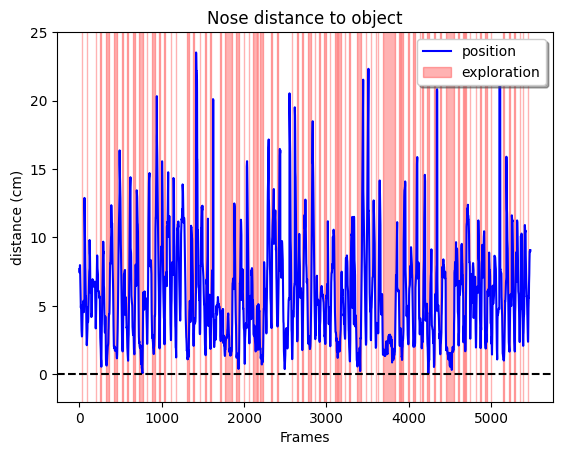

In [7]:
# Plot the data before training
rst.plot_example_data(X_ts, y_ts)

Lets get some tools ready for model training:

- Early stopping
- Scheduled learning rate

Now we train the first model

In [8]:
# Build a simple neural network
model_simple = tf.keras.Sequential([
    Input(shape=(X_tr.shape[1],)),

    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(16, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,925
Trainable params: 1,925
Non-trainabl

In [10]:
# Train the model
history_simple = model_simple.fit(X_tr, y_tr,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_val, y_val))

Epoch 1/10
828/828 [==============================] - 4s 4ms/step - loss: 0.4394 - accuracy: 0.5817 - val_loss: 0.3570 - val_accuracy: 0.6196
Epoch 2/10
828/828 [==============================] - 3s 4ms/step - loss: 0.3219 - accuracy: 0.6624 - val_loss: 0.2698 - val_accuracy: 0.7049
Epoch 3/10
828/828 [==============================] - 4s 5ms/step - loss: 0.2571 - accuracy: 0.6969 - val_loss: 0.2257 - val_accuracy: 0.7160
Epoch 4/10
828/828 [==============================] - 4s 5ms/step - loss: 0.2328 - accuracy: 0.7006 - val_loss: 0.2183 - val_accuracy: 0.7172
Epoch 5/10
828/828 [==============================] - 4s 5ms/step - loss: 0.2233 - accuracy: 0.7019 - val_loss: 0.2149 - val_accuracy: 0.7169
Epoch 6/10
828/828 [==============================] - 4s 5ms/step - loss: 0.2184 - accuracy: 0.7033 - val_loss: 0.2120 - val_accuracy: 0.7170
Epoch 7/10
828/828 [==============================] - 4s 5ms/step - loss: 0.2144 - accuracy: 0.7037 - val_loss: 0.2111 - val_accuracy: 0.7176
Epoch 

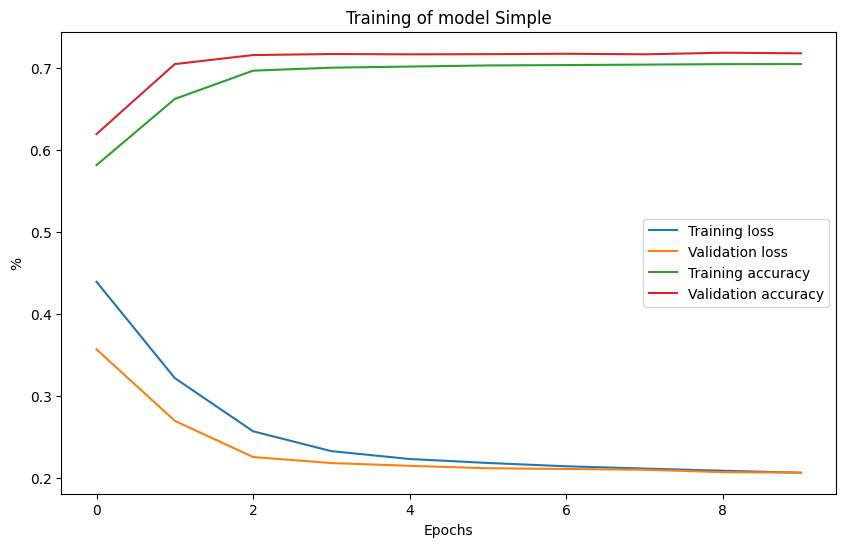

In [11]:
# Plot the training and validation loss
rst.plot_history(history_simple, "Simple")

In [12]:
# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple = rst.evaluate(X_ts, y_ts, model_simple)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")

mse_simple, mae_simple, r2_simple = rst.evaluate_continuous(X_ts, y_ts, model_simple)
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

172/172 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4138
           1       0.80      0.85      0.83      1341

    accuracy                           0.91      5479
   macro avg       0.88      0.89      0.89      5479
weighted avg       0.92      0.91      0.91      5479

Accuracy = 0.9135, Precision = 0.9158, Recall = 0.9135, F1 Score = 0.9144 -> simple
172/172 [==============================] - 0s 1ms/step
MSE = 0.0452, MAE = 0.1037, R-squared = 0.7254 -> simple


In [13]:
# Save the model
model_simple.save(os.path.join(models_folder, f'simple/model_simple_{start_time.date()}.keras'))

---
#### Now that we have a simple model trained, we can start building more complex models with the help of some functions

Lets move onto training a Recursive Network (that can see sequences)

Now that we have our simple and wide models covered, lets implement one last change to make this artificial network as real as possible...
* By using Bidirectional() we will allow the model to take into account the sequence of frames
* Lets also define a function to create and easily modify models

In [14]:
# Set the number of neurons in each layer
input_shape = (X_tr_wide.shape[1], X_tr_wide.shape[2])
units = [32, 24, 16, 12, 8]

batch_size = 32 # Set the batch size
lr = 0.00012 # Set the initial learning rate
epochs = 60 # Set the training epochs

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, mode='min', verbose=1)

# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    decay_factor = 0.9  # Learning rate decay factor
    decay_epochs = 6    # Number of epochs after which to decay the learning rate
    
    # Calculate the new learning rate
    return lr * (decay_factor ** (epoch // decay_epochs))

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [15]:
# Build model
model_wide = rst.build_LSTM_model(input_shape, units)

# Compile model
model_wide.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model_wide.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 12)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 7, 64)            11520     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 7, 64)            256       
 ormalization)                                                   
                                                                 
 layer_normalization (LayerN  (None, 7, 64)            128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                             

In [17]:
# Train the model
history_wide = model_wide.fit(X_tr_wide, y_tr,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/60
828/828 [==============================] - 46s 44ms/step - loss: 0.3351 - accuracy: 0.6687 - val_loss: 0.2583 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 2/60
828/828 [==============================] - 34s 41ms/step - loss: 0.2649 - accuracy: 0.6926 - val_loss: 0.2505 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 3/60
828/828 [==============================] - 34s 41ms/step - loss: 0.2393 - accuracy: 0.7002 - val_loss: 0.2226 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 4/60
828/828 [==============================] - 34s 41ms/step - loss: 0.2234 - accuracy: 0.7045 - val_loss: 0.2567 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 5/60
828/828 [==============================] - 34s 41ms/step - loss: 0.2095 - accuracy: 0.7072 - val_loss: 0.2067 - val_accuracy: 0.7215 - lr: 0.0010
Epoch 6/60
828/828 [==============================] - 34s 41ms/step - loss: 0.2027 - accuracy: 0.7088 - val_loss: 0.2130 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 7/60
828/828 [==============================] - 34s 

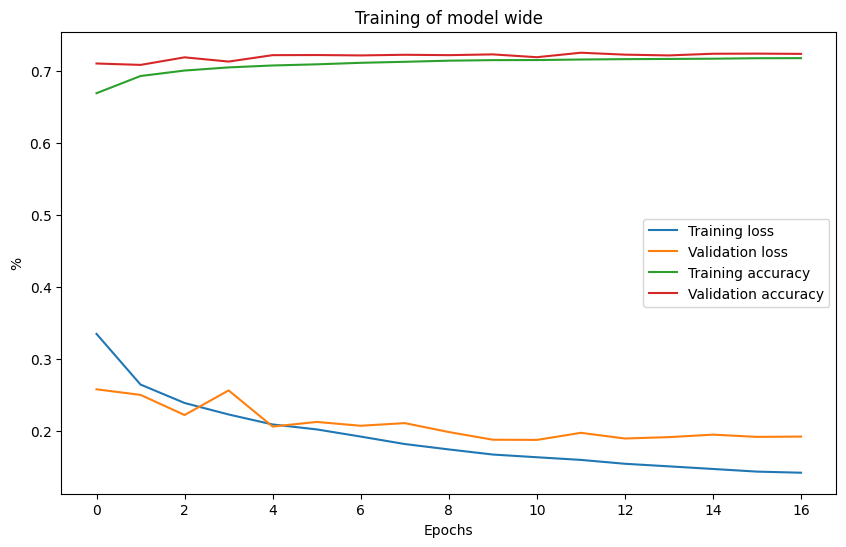

In [18]:
# Plot the training and validation loss
rst.plot_history(history_wide, "wide")

In [26]:
# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide = rst.evaluate(X_ts_wide, y_ts, model_wide)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")

mse_wide, mae_wide, r2_wide = rst.evaluate_continuous(X_ts_wide, y_ts, model_wide)
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

172/172 [==============================] - 3s 16ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4138
           1       0.82      0.82      0.82      1341

    accuracy                           0.91      5479
   macro avg       0.88      0.88      0.88      5479
weighted avg       0.91      0.91      0.91      5479

Accuracy = 0.9097, Precision = 0.9096, Recall = 0.9097, F1 Score = 0.9096 -> wide
172/172 [==============================] - 2s 14ms/step
MSE = 0.0476, MAE = 0.1017, R-squared = 0.7106 -> wide


In [27]:
# Save the model
model_wide.save(os.path.join(models_folder, f'wide/model_wide_{start_time.date()}.keras'))

Lets also train a Random Forest model

In [28]:
# We train a RF model with the same data, but first we make it discrete
y_tr = (y_tr > 0.5).astype(int)

# Create the Random Forest model (and set the number of estimators (decision trees))
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier with your data
RF_model.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [29]:
# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF = rst.evaluate(X_ts, y_ts, RF_model)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

mse_RF, mae_RF, r2_RF = rst.evaluate_continuous(X_ts, y_ts, RF_model)
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      4138
           1       0.81      0.87      0.84      1341

    accuracy                           0.92      5479
   macro avg       0.88      0.90      0.89      5479
weighted avg       0.92      0.92      0.92      5479

Accuracy = 0.9182, Precision = 0.9207, Recall = 0.9182, F1 Score = 0.9191 -> RF
MSE = 0.0642, MAE = 0.0874, R-squared = 0.6095 -> RF


In [30]:
# Save the model
joblib.dump(RF_model, os.path.join(models_folder, f'RF/model_RF_{start_time.date()}.pkl'))

['C:/Users/dhers/Desktop/RAINSTORM/docs/models\\RF/model_RF_2024-11-25.pkl']

In [31]:
# Print the model results
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9135, Precision = 0.9158, Recall = 0.9135, F1 Score = 0.9144 -> simple
Accuracy = 0.9097, Precision = 0.9096, Recall = 0.9097, F1 Score = 0.9096 -> wide
Accuracy = 0.9182, Precision = 0.9207, Recall = 0.9182, F1 Score = 0.9191 -> RF
VS continuous average
MSE = 0.0452, MAE = 0.1037, R-squared = 0.7254 -> simple
MSE = 0.0476, MAE = 0.1017, R-squared = 0.7106 -> wide
MSE = 0.0642, MAE = 0.0874, R-squared = 0.6095 -> RF
